# Practice Field Data Analysis

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML
import csv

## Read in the data from 5x4 teleop

this was one of the trials that actually recorded properly

In [11]:
reader = csv.reader(open("./recorded_sensor_data/field_data_2/auto/mocap_data-175.173.csv", 'r'))  # not actually mocap data
headers = next(reader)
sensor_data = []
for row in reader:
    data = [float(d) for d in row]
    sensor_data.append(data)
    
# sensor data is a Nx15 array. N is the number of data points
sensor_data = np.array(sensor_data)
print("sensor_data shape:", sensor_data.shape)
print("idx header")
for i, h in enumerate(headers):
    print(i, h)

sensor_data shape: (4130, 16)
idx header
0 raw_accel_x
1 raw_accel_y
2 raw_accel_z
3 world_accel_x
4 world_accel_y
5 yaw
6 fused_heading
7 x
8 y
9 z
10 left_encoder_rate
11 right_encoder_rate
12 left_input
13 right_input
14 fpga time
15 navx time


## Integrate gyro Z to get yaw

In [13]:
yaws = []
yaw = 0
for data in sensor_data:
    gyro_z = -data[5]  # the negative sign is to tf into mocap frame
    yaw += 0.02 * gyro_z
    yaws.append(yaw)

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title("Yaw of robot")

cursor, = ax.plot([], [], lw=2)
def init():
    ax.plot(yaws, label='yaw')
    ax.set_xlabel('sample idx')
    ax.set_ylabel("degrees")
    cursor.set_data([0, 0], ax.get_ylim())
    return (cursor,)

scale = 10
def animate(i):
    x = [i*scale, i*scale]
    cursor.set_data(x, ax.get_ylim())
    return (cursor,)

anim = animation.FuncAnimation(fig, animate, frames=len(yaws)//scale, init_func=init, interval=scale*21)
html = anim.to_html5_video()
html += '<video width="320" height="240" controls><source src="./recorded_sensor_data/field_data_1/5x4_teleop/out_01_01_01-17-23.mp4" type="video/mp4"></video>'
HTML(html)

If you play this along side the video of the robot you can see they seem quite reasonable. 

# Sensor data from the second round of testing

The data recorded in these tests is different from the data recorded in the first test.

In [21]:
reader = csv.reader(open("./recorded_sensor_data/field_data_2/auto/mocap_data-175.173.csv", 'r'))  # not actually mocap data
headers = next(reader)
sensor_data = []
for idx, row in enumerate(reader):
    data = [float(d) for d in row]
    # wrap fused heading to match Yaw range
    if data[6] > 180:
        data[6] = -360 + data[6]
    sensor_data.append(data)
    
# sensor data is a Nx15 array. N is the number of data points
sensor_data = np.array(sensor_data)
print("sensor_data shape:", sensor_data.shape)
print("idx header")
for i, h in enumerate(headers):
    print(i, h)

sensor_data shape: (4130, 16)
idx header
0 raw_accel_x
1 raw_accel_y
2 raw_accel_z
3 world_accel_x
4 world_accel_y
5 yaw
6 fused_heading
7 x
8 y
9 z
10 left_encoder_rate
11 right_encoder_rate
12 left_input
13 right_input
14 fpga time
15 navx time


## Encoders

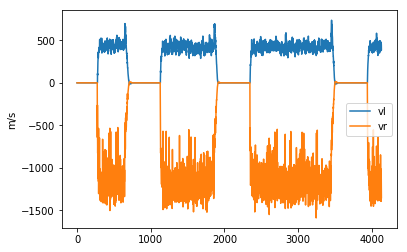

In [32]:
plt.figure()
plt.plot(sensor_data[:,10], label='vl')
plt.plot(sensor_data[:,11], label='vr')
plt.legend()
plt.ylabel("m/s")
plt.show()

In [65]:
encoder_xs = []
encoder_ys = []
encoder_yaws = []
encoder_x = 0
encoder_y = 0
encoder_yaw = 0
alpha = 0.13
wheel_radius_m = 0.074
track_width_m = 0.9
dt_s = 0.05
for data in sensor_data:
    wl = data[10] * 0.000357
    wr = data[11] * 0.000357
    
    B = alpha * track_width_m
    T = wheel_radius_m / B * np.array([[B / 2.0, B / 2.0], [-1, 1]])
    dydt, dpdt = T @ np.array([wl, wr])
    encoder_x = encoder_x + np.cos(encoder_yaw) * dydt * dt_s
    encoder_y = encoder_y + np.sin(encoder_yaw) * dydt * dt_s
    encoder_yaw += dpdt * dt_s
    
    encoder_xs.append(encoder_x)
    encoder_ys.append(encoder_y)
    encoder_yaws.append(encoder_yaw)

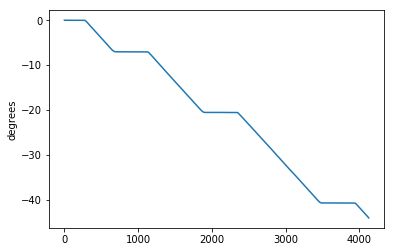

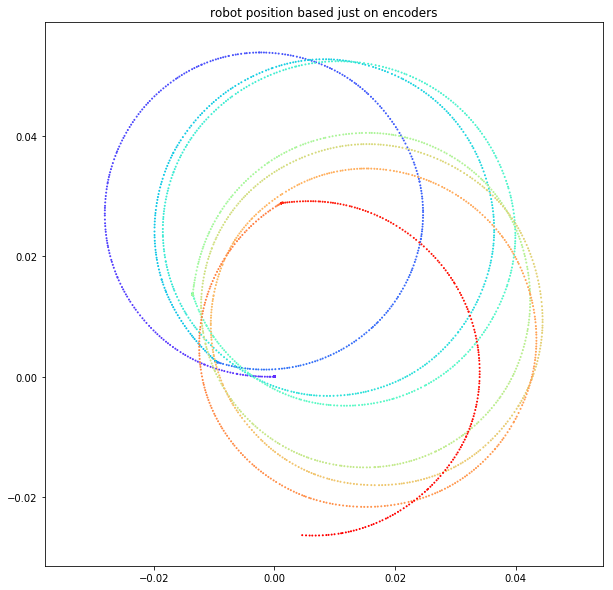

In [66]:
plt.figure()
plt.plot(encoder_yaws)
plt.ylabel("degrees")
plt.show()

plt.figure(figsize=(10,10))
colors = cm.rainbow(np.linspace(0, 1, len(encoder_xs)))
plt.scatter(encoder_xs, encoder_ys, s=1, color=colors)
plt.title("robot position based just on encoders")
plt.axis("equal")
plt.show()

## Plot the Yaw() versus FusedHeading()

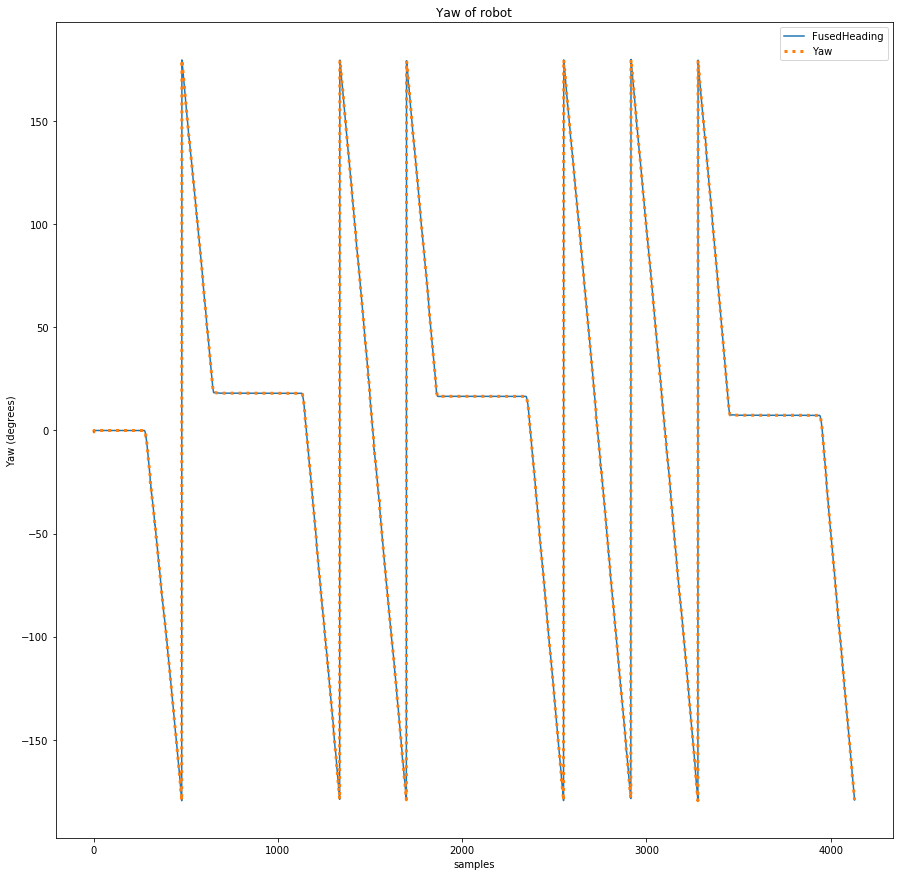

In [25]:
plt.figure(figsize=(15,15))
plt.plot(sensor_data[:,6], label="FusedHeading")
plt.plot(sensor_data[:,5], linestyle=":", linewidth=3, label="Yaw")
plt.title("Yaw of robot")
plt.xlabel("samples")
plt.ylabel("Yaw (degrees)")
plt.legend()
plt.show()

The moral of the story is they are basically the same so it doesn't matter which we use.

## Plot acceleration & double integrate

In [26]:
def PositionFromIMU(imu_data, dt_s, x0, y0, yaw0):
    """
    This is the double integration method
    
    Args:
        imu_data (ndarray(?x3)) the columns are world linear x & y
        dt_s (float) the time between samples in imu_data in seconds
        x0 (float) initial x position
        y0 (float) initial y position
        yaw0 (float) initial yaw angle
    """
    x = x0
    y = y0
    vx = 0
    vy = 0
    xs = []
    ys = []
    vxs = []
    vys = []
    axs = []
    ays = []
    for d in imu_data:
        ax = d[0]
        ay = d[1]
        
        x += vx * dt_s + 0.5 * ax * (dt_s ** 2)
        y += vy * dt_s + 0.5 * ay * (dt_s ** 2)
        vx += ax * dt_s
        vy += ay * dt_s
                
        axs.append(ax)
        ays.append(ay)
        vxs.append(vx)
        vys.append(vy)
        xs.append(x)
        ys.append(y)
    
    return xs, ys, vxs, vys, axs, ays

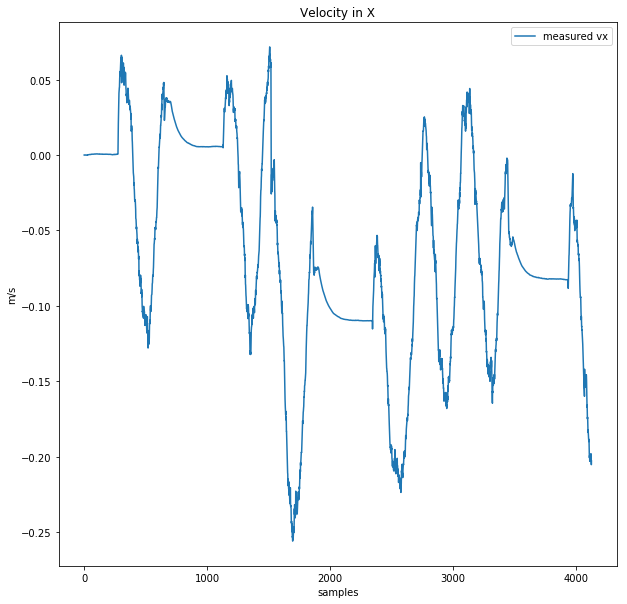

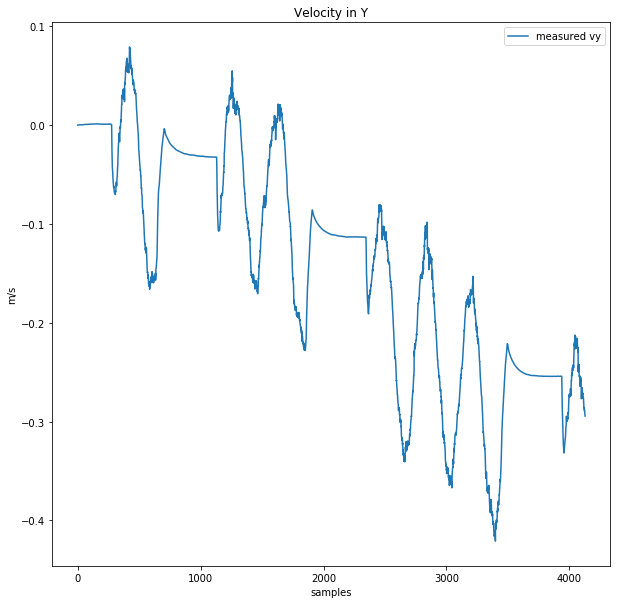

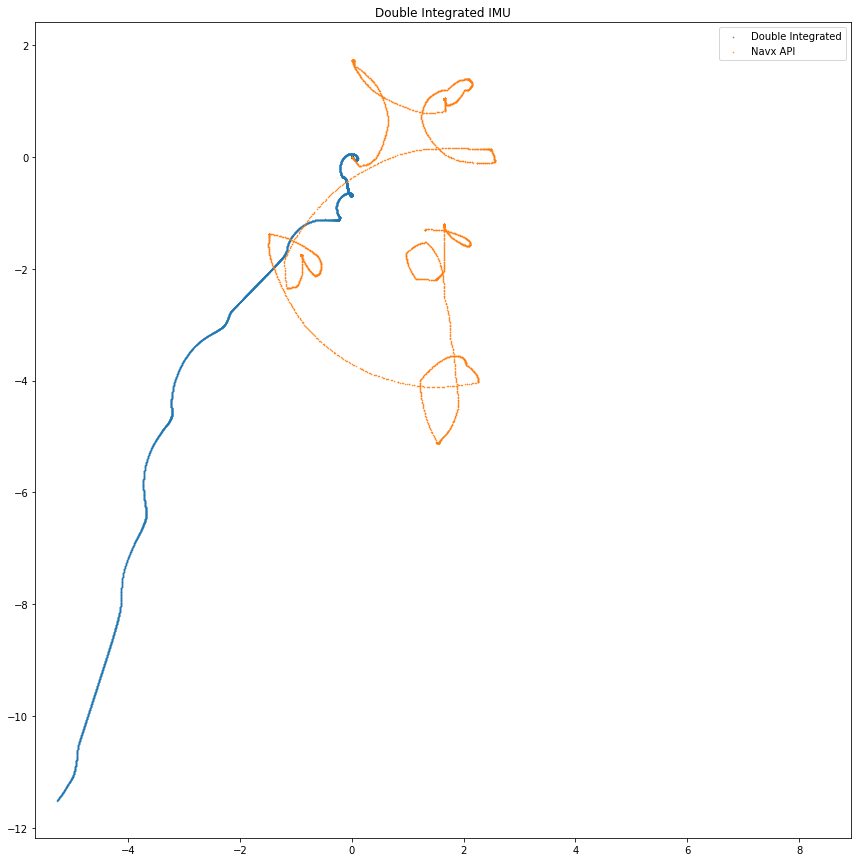

In [27]:
pva = PositionFromIMU(sensor_data[:, 3:6], dt_s=0.02, x0=0, y0=0, yaw0=0)

plt.figure(figsize=(10,10))
plt.plot(pva[2], label='measured vx')
plt.legend()
plt.title("Velocity in X")
plt.ylabel("m/s")
plt.xlabel("samples")
plt.show()

plt.figure(figsize=(10,10))
plt.plot(pva[3], label='measured vy')
plt.legend()
plt.title("Velocity in Y")
plt.ylabel("m/s")
plt.xlabel("samples")
plt.show()

plt.figure(figsize=(15,15))
plt.title("Double Integrated IMU")
plt.scatter(pva[0], pva[1], marker='.', s=1, label='Double Integrated')
plt.scatter(sensor_data[:,7], sensor_data[:,8], marker='.', s=1, label='Navx API')
plt.axis("square")
plt.legend()
plt.show()